In [1]:
import pandas as pd
import torch
import numpy as np

# LRAP. Instance-level average
# Assume float preds [BxC], labels [BxC] of 0 or 1
def LRAP(preds, labels):
    # Ranks of the predictions
    ranked_classes = torch.argsort(preds, dim=-1, descending=True)
    # i, j corresponds to rank of prediction in row i
    class_ranks = torch.zeros_like(ranked_classes)
    for i in range(ranked_classes.size(0)):
        for j in range(ranked_classes.size(1)):
            class_ranks[i, ranked_classes[i][j]] = j + 1
    # Mask out to only use the ranks of relevant GT labels
    ground_truth_ranks = class_ranks * labels + (1e6) * (1 - labels)
    # All the GT ranks are in front now
    sorted_ground_truth_ranks, _ = torch.sort(ground_truth_ranks, dim=-1, descending=False)
    pos_matrix = torch.tensor(np.array([i+1 for i in range(labels.size(-1))])).unsqueeze(0)
    score_matrix = pos_matrix / sorted_ground_truth_ranks
    score_mask_matrix, _ = torch.sort(labels, dim=-1, descending=True)
    scores = score_matrix * score_mask_matrix
    score = (scores.sum(-1) / labels.sum(-1)).mean()
    return score.item()

# label-level average
# Assume float preds [BxC], labels [BxC] of 0 or 1
def LWLRAP(preds, labels):
    preds = preds.to('cpu')
    labels = labels.to('cpu')

    labels[labels > 0.0] = 1.0  # label smoothingする場合もスコア計算のため1にしてしまう
    # Ranks of the predictions
    ranked_classes = torch.argsort(preds, dim=-1, descending=True)
    # i, j corresponds to rank of prediction in row i
    class_ranks = torch.zeros_like(ranked_classes)
    for i in range(ranked_classes.size(0)):
        for j in range(ranked_classes.size(1)):
            class_ranks[i, ranked_classes[i][j]] = j + 1
    # Mask out to only use the ranks of relevant GT labels
    ground_truth_ranks = class_ranks * labels + (1e6) * (1 - labels)
    # All the GT ranks are in front now
    sorted_ground_truth_ranks, _ = torch.sort(ground_truth_ranks, dim=-1, descending=False)
    # Number of GT labels per instance
    # num_labels = labels.sum(-1)
    pos_matrix = torch.tensor(np.array([i+1 for i in range(labels.size(-1))])).unsqueeze(0)
    score_matrix = pos_matrix / sorted_ground_truth_ranks
    score_mask_matrix, _ = torch.sort(labels, dim=-1, descending=True)
    scores = score_matrix * score_mask_matrix
    score = scores.sum() / labels.sum()
    return score.item()

In [2]:

input_dir = "../oof/"
oof = pd.read_csv(input_dir + "fold0_oof.csv")
# oof1 = pd.read_csv(input_dir + "fold1_oof.csv")
# oof2 = pd.read_csv(input_dir + "fold2_oof.csv")
# oof3 = pd.read_csv(input_dir + "fold3_oof.csv")
# oof4 = pd.read_csv(input_dir + "fold4_oof.csv")
# oof = pd.concat([oof0, oof1, oof2, oof3, oof4])
oof

,patch,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,0,003bec244,0.224785,0.938255,0.453482,0.886388,0.023673,0.270250,0.229986,0.961596,...,0.877904,0.325141,0.101655,0.006542,0.272909,0.025911,0.055870,0.241524,0.025974,0.035949
1,1,003bec244,0.093940,0.705315,0.477549,0.863966,0.043578,0.026179,0.675047,0.892303,...,0.817091,0.170741,0.191048,0.023601,0.234074,0.021188,0.160787,0.260731,0.011710,0.032931
2,2,003bec244,0.072486,0.498256,0.121884,0.925243,0.017588,0.007010,0.143198,0.985987,...,0.915609,0.112248,0.030830,0.005296,0.249234,0.007596,0.096299,0.129374,0.007183,0.009200
3,3,003bec244,0.046064,0.561206,0.383785,0.833069,0.056129,0.010810,0.093832,0.953552,...,0.576984,0.227663,0.015548,0.003902,0.287859,0.022225,0.027605,0.139974,0.009428,0.014190
4,4,003bec244,0.070032,0.582789,0.222043,0.887702,0.025063,0.021475,0.139246,0.946979,...,0.924343,0.101117,0.060073,0.007168,0.221703,0.023084,0.094915,0.162247,0.012268,0.024260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7547,3,ffc51b999,0.996503,0.333781,0.215768,0.664977,0.046107,0.019413,0.135177,0.211562,...,0.342423,0.046560,0.020370,0.002940,0.955427,0.106430,0.006569,0.063820,0.148207,0.139865
7548,4,ffc51b999,0.159638,0.146730,0.064710,0.425025,0.008677,0.287831,0.033166,0.288085,...,0.340784,0.018422,0.034900,0.015733,0.960277,0.066328,0.011918,0.048713,0.025891,0.094845
7549,5,ffc51b999,0.252424,0.185425,0.167412,0.376062,0.032171,0.432011,0.098821,0.191079,...,0.334049,0.032597,0.255667,0.027181,0.949590,0.224146,0.020879,0.097528,0.069608,0.122578
7550,6,ffc51b999,0.188182,0.164324,0.144242,0.487652,0.025432,0.325569,0.132655,0.284492,...,0.314385,0.032563,0.067355,0.059773,0.931838,0.105765,0.025966,0.082349,0.065179,0.118189


In [3]:
oof2 = oof.groupby('recording_id').max().reset_index(drop=False)
oof2

,recording_id,patch,s0,s1,s2,s3,s4,s5,s6,s7,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,003bec244,7,0.224785,0.938255,0.477549,0.949893,0.056129,0.270250,0.675047,0.985987,...,0.924343,0.325141,0.191048,0.023601,0.328566,0.025911,0.160787,0.286745,0.025974,0.040307
1,00d442df7,7,0.999405,0.531444,0.148184,0.963154,0.018562,0.013061,0.123996,0.518725,...,0.825003,0.125325,0.049231,0.004225,0.993038,0.004533,0.018522,0.698755,0.586532,0.075230
2,00e3525a2,7,0.222221,0.529003,0.563542,0.893082,0.121859,0.080871,0.795861,0.924394,...,0.588073,0.266694,0.155706,0.814692,0.524360,0.203330,0.646057,0.334123,0.040228,0.113811
3,016240b9a,7,0.215922,0.462290,0.629682,0.885337,0.063169,0.189922,0.196283,0.934764,...,0.621936,0.185337,0.163028,0.118330,0.658762,0.057470,0.310024,0.268857,0.999988,0.098474
4,01a976045,7,0.114642,0.872923,0.546411,0.935300,0.043971,0.048342,0.110733,0.902361,...,0.572105,0.227934,0.788759,0.531906,0.190128,0.032923,0.066075,0.216980,0.013409,0.122400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,ff61d0146,7,0.117750,0.465640,0.271244,0.853724,0.073773,0.207336,0.385718,0.969690,...,0.426827,0.182625,0.183811,0.167775,0.412293,0.112215,0.168298,0.252565,0.231599,0.196198
940,ff7f876bd,7,0.998873,0.560581,0.108299,0.979608,0.032391,0.120315,0.148207,0.495050,...,0.343244,0.245826,0.030476,0.018284,0.984968,0.008631,0.009635,0.146956,0.073106,0.128705
941,ff8492f71,7,0.999149,0.339498,0.080261,0.953122,0.012572,0.041486,0.047220,0.545522,...,0.730989,0.079544,0.029516,0.005493,0.985442,0.006046,0.021280,0.566158,0.880556,0.081355
942,ffb8d8391,7,0.713875,0.354477,0.319670,0.969649,0.265769,0.838014,0.310212,0.541224,...,0.699285,0.668637,0.451797,0.178962,0.972867,0.370032,0.125026,0.443798,0.440495,0.153343


In [4]:
tp = pd.read_csv("../input/rfcx-species-audio-detection/train_tp.csv")
tp_fnames, tp_labels = [], []
for recording_id, df in tp.groupby("recording_id"):
    v = sum([np.eye(24)[i] for i in df["species_id"].tolist()])
    v = (v >= 1).astype(int).tolist()
    tp_fnames.append(recording_id)
    tp_labels.append(v) 

tp2 = pd.DataFrame(tp_labels, columns=[f's{i}' for i in range(24)])
tp2['recording_id'] = tp_fnames
tp2 = tp2.sort_values('recording_id')
tp2


,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s15,s16,s17,s18,s19,s20,s21,s22,s23,recording_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,003bec244
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,006ab765f
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,007f87ba2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0099c367b
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,009b760e6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fe8d9ac40
1128,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fea6b438a
1129,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ff2eb9ce5
1130,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ffb8d8391


In [5]:
tp_oof = oof2[oof2['recording_id'].isin(tp2['recording_id'])].reset_index(drop=True).sort_values('recording_id')
tp_oof

,recording_id,patch,s0,s1,s2,s3,s4,s5,s6,s7,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,003bec244,7,0.224785,0.938255,0.477549,0.949893,0.056129,0.270250,0.675047,0.985987,...,0.924343,0.325141,0.191048,0.023601,0.328566,0.025911,0.160787,0.286745,0.025974,0.040307
1,00d442df7,7,0.999405,0.531444,0.148184,0.963154,0.018562,0.013061,0.123996,0.518725,...,0.825003,0.125325,0.049231,0.004225,0.993038,0.004533,0.018522,0.698755,0.586532,0.075230
2,0275e127d,7,0.094659,0.409909,0.442396,0.781116,0.150064,0.031237,0.500361,0.871352,...,0.347130,0.374402,0.043625,0.746018,0.321698,0.067598,0.147533,0.130477,0.041919,0.103071
3,0295e3234,7,0.198660,0.437504,0.549462,0.806858,0.229857,0.089149,0.797226,0.888579,...,0.370906,0.997015,0.031956,0.544349,0.506065,0.163756,0.115173,0.154768,0.180492,0.857058
4,03d77fede,7,0.998730,0.571195,0.093456,0.964953,0.058642,0.056750,0.161615,0.432942,...,0.351543,0.215448,0.043973,0.016372,0.990337,0.021516,0.008131,0.132697,0.062489,0.101647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,fc6609050,7,0.998029,0.667587,0.140595,0.980973,0.036098,0.003693,0.135568,0.439483,...,0.387405,0.162123,0.012306,0.001320,0.990952,0.004029,0.003525,0.177074,0.018314,0.063680
221,fd3f0d49b,7,0.899697,0.385484,0.464764,0.860252,0.114531,0.088624,0.999944,0.982538,...,0.570869,0.853118,0.160930,0.084598,0.779519,0.154542,0.867195,0.202058,0.016283,0.508905
222,fd6a520d8,7,0.710136,0.429841,0.243154,0.958707,0.106409,0.349843,0.150692,0.522888,...,0.626465,0.234584,0.063270,0.044277,0.964712,0.076386,0.031524,0.589022,0.979537,0.199227
223,fdda158ed,7,0.898943,0.080530,0.026589,0.975514,0.061608,0.160734,0.046643,0.366795,...,0.686624,0.115819,0.152827,0.032738,0.959637,0.024680,0.057321,0.793698,0.993515,0.131588


In [6]:
tp2 = tp2[tp2["recording_id"].isin(tp_oof["recording_id"])]

In [7]:
pred = tp_oof.loc[:, 's0':'s23'].values
target = tp2.loc[:, 's0':'s23'].values

In [8]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
auc = roc_auc_score(target, pred, average=None)
auc

array([0.98837209, 0.97069767, 0.98249619, 0.70372093, 0.89767442,
       0.98046512, 1.        , 0.92232558, 0.95348837, 0.98951507,
       0.99537037, 0.97023256, 0.95209302, 0.99767442, 0.98139535,
       0.9827907 , 1.        , 0.97069767, 0.9172093 , 0.98387097,
       0.99868938, 0.97069767, 0.99639918, 0.96967257])

<BarContainer object of 24 artists>

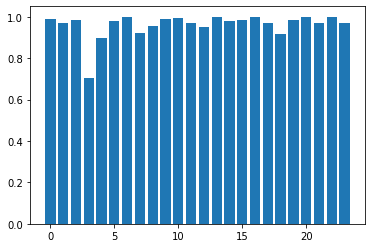

In [9]:
plt.bar(np.arange(24), auc)

In [10]:
pred = torch.tensor(pred)
target = torch.tensor(target)
pred.shape, target.shape

(torch.Size([225, 24]), torch.Size([225, 24]))

In [11]:
original_lwlrap = LWLRAP(pred, target)
original_lwlrap

0.7392822504043579